Get the data or create random dataset

In [1]:
from ctrl import utils

# data = utils.generate_random_dataset(10, 50)
data = utils.load_data()

Plot an example EMA/EMI trajectory

Calculate 
- the model predictions $\hat{x}_{t+1} = Ax_t + Bu_t$ 
- the fraction of variance explained per subject 
- the observed and predicted effects of all EMI types: for each $k=1,2,3,4: (x_{t+1} - x_t) \quad \forall t: u_t = e_k$
- the predicted differences without including the EMI ($\hat{x}_{t+1} = Ax_t$)
- the observed and predicted effects given any kind of EMI: $(x_{t+1} - x_t) \quad \forall t: u_t \neq 0$

In [2]:
import warnings
import numpy as np
from ctrl import discrete_optimal_control as doc

N = len(data)
n_feat = len(data[0]['Xlabs'])
n_emis = len(data[0]['Ilabs'])
determination_coeff = np.zeros((N, n_feat))
r_squared = np.zeros((N, n_feat))
emi_effects = np.zeros((N, n_emis, n_feat))
predicted_effects = np.zeros((N, n_emis, n_feat))
predicted_effects_without_inputs = np.zeros((N, n_emis, n_feat))
any_emi_effects = np.zeros((N, n_feat))
any_predicted_effects = np.zeros((N, n_feat))

for j, d in enumerate(data):
    Xnan = data[j]['Xnan']
    prediction = doc.step(d['A'], d['B'], d['X'], d['Inp'])[:-1]
    prediction[np.isnan(Xnan[:-1]) ] = np.nan   # We only analyze the data which is not missing (leaving out imputed data)

    for f in range(n_feat):
        mask = ~np.isnan(Xnan[1:][:,f]) & ~np.isnan(prediction[:,f])
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            r_squared[j,f] = np.corrcoef(prediction[mask,f], Xnan[1:][mask, f])[0,1]**2

    A_wi, _, _ = utils.stable_ridge_regression(d['X'], d['Inp'])
    prediction_without_inputs = (d['A'] @ d['X'].T).T[:-1]

    with warnings.catch_warnings():
        warnings.simplefilter('ignore') 
        for e in range(n_emis):
            Xnan_before = Xnan[:-1][d['Inp'][:-1,e]==1]
            Xnan_after = Xnan[1:][d['Inp'][:-1,e]==1]        
            emi_effects[j,e] = np.nanmean(Xnan_after - Xnan_before, axis=0)
            predicted_after = prediction[d['Inp'][:-1,e]==1]
            predicted_effects[j,e] = np.nanmean((predicted_after - Xnan_before), axis=0)
            predicted_after_without_inputs = prediction_without_inputs[d['Inp'][:-1,e]==1]
            predicted_effects_without_inputs[j,e] = np.nanmean((predicted_after_without_inputs - Xnan_before), axis=0)
        any_emi_effects[j] = np.nanmean(Xnan[1:][d['Inp'][:-1].any(1)] - Xnan[:-1][d['Inp'][:-1].any(1)], axis=0)
        any_predicted_effects[j] = np.nanmean(prediction[d['Inp'][:-1].any(1)] - Xnan[:-1][d['Inp'][:-1].any(1)], axis=0)

Calculate the between-subject mean and std of the fraction of variance explained by the model predictions

In [3]:
print(f"1-step ahead prediction: across-subject mean R^2={np.nanmean(r_squared)}, std={np.nanstd(r_squared)}")

1-step ahead prediction: across-subject mean R^2=0.45801051902681233, std=0.2830879055317403


Plot the variance explained per EMA item

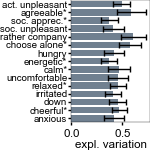

In [5]:
from scipy.stats import sem
import matplotlib.pyplot as plt
import matplotlib as mpl
import custom_rcparams_paper as crc

with mpl.rc_context({'ytick.labelsize':'x-small'}):
    fig, ax = plt.subplots(1,1, figsize=(1.5,1.5))
    ax.barh(range(n_feat), np.nanmean(r_squared, axis=0), color=crc.colors.features,
                xerr=sem(r_squared, axis=0, nan_policy='omit'), error_kw={'linewidth':1}, ecolor=crc.colors.errorbars)
    ax.set_yticks(np.arange(n_feat), labels=data[0]['Xlabs'])
    ax.set_ylim((-0.5, n_feat-0.5))
    ax.set_xlabel('expl. variation')
    fig.savefig('figures/S2b.png')
    plt.show()

Calculate the subject mean predicted and empirical EMI effects (with and without inputs in the model)

In [6]:
from scipy.stats import pearsonr

predicted_effects[np.isnan(emi_effects)] = np.nan
predicted_effects_without_inputs[np.isnan(emi_effects)] = np.nan
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    predicted_effects = np.nanmean(predicted_effects, axis=0)
    predicted_effects_without_inputs = np.nanmean(predicted_effects_without_inputs, axis=0)
    emi_effects = np.nanmean(emi_effects, axis=0)

Calculate the fraction of effect variance explained when separating EMI types and EMA items and taking the mean over participants

In [7]:
flat_emi_effects = emi_effects.flatten()
flat_predicted_effects = predicted_effects.flatten()
mask = (~np.isnan(flat_emi_effects)) & (~np.isnan(flat_predicted_effects))
corr = pearsonr(flat_predicted_effects[mask], flat_emi_effects[mask])
print(f'Empirical vs. predicted EMI effects: r={corr.statistic}, p={corr.pvalue}, R^2={corr.statistic**2}')

flat_pred_eff_without_inputs = predicted_effects_without_inputs.flatten()
mask = (~np.isnan(flat_emi_effects)) & (~np.isnan(flat_pred_eff_without_inputs))
corr_without_inputs = pearsonr(flat_pred_eff_without_inputs[mask], flat_emi_effects[mask])
print(f'Empirical vs. predicted EMI effects without inputs: r={corr_without_inputs.statistic}, p={corr_without_inputs.pvalue}, R^2={corr_without_inputs.statistic**2}')

Empirical vs. predicted EMI effects: r=0.8815765160099452, p=6.333633173631178e-18, R^2=0.7771771535802332
Empirical vs. predicted EMI effects without inputs: r=0.6168771593758171, p=1.1162501498001623e-06, R^2=0.3805374297595773


Plot the predicted against observed effect of EMI

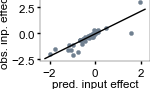

In [8]:
fig, ax = plt.subplots(1,1,figsize=(1.5,0.9))
ax, corr = utils.plot_regression(predicted_effects.flatten(), emi_effects.flatten(), 
                      scatter_kwargs={'color':crc.colors.standard}, line_kwargs={'color':'k'}, ax=ax,
                      nan_policy='omit')
ax.set_xlabel('pred. input effect')
ax.set_ylabel('obs. inp. effect')
fig.savefig('figures/S2c.png')
plt.show()

Calculate the fraction of effect variance explained when taking the mean over EMI types and EMA items

In [9]:
corr_any_emi = pearsonr(np.nanmean(any_predicted_effects, axis=1), np.nanmean(any_emi_effects, axis=1))
print(f'Empirical vs. predicted EMI effects: r={corr_any_emi.statistic}, p={corr_any_emi.pvalue}, R^2={corr_any_emi.statistic**2}')

Empirical vs. predicted EMI effects: r=0.6289524035233367, p=0.05140918395079315, R^2=0.39558112589778216


Calculate the difference in variance explained between predicted differences with and without inputs

In [10]:
print(f'F Test between prediction accuracies with and : F={corr.statistic**2 / corr_without_inputs.statistic**2}, '
      f'df1={sum(mask)-1}, df2={sum(mask)-1}')

F Test between prediction accuracies with and : F=2.042314612970535, df1=51, df2=51
